# <font color=dodgerblue> Collect the choice point and reward port limits from video files
    
***
   #### Selection of two frames per video in the given video_files_path
   #### Open in loop each frame
   #### Detection of RW1 (Left) and RW2 (Right) ports, CP (choice point square) ROI in frames in pixels
   ####  Conversion of ROIs to CROP POLYGON dimensions (rat dependent)
   #### Conversion of ROI dimensions from px to cm
***


### <font color=firebrick>Imports
***

In [1]:
import cv2
import os
import re
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.widgets  import RectangleSelector
from open_files import get_file_list

%matplotlib inline

### <font color=firebrick>Inputs
***

In [2]:
# The path where the video files are stored. Create ROIS and ROI_Frames folders
video_files_path = "E:\POSITION DATA/GERONIMO_CTRL5"

### <font color=firebrick> Functions
***

In [15]:
def select_and_save_frame_from_videos_in_path(path):
    
    '''
    Find first frame of each video a save it as a .jpg image
    '''
    # Get the video list
    video_list = get_file_list(video_files_path, "*.avi")
    
    # Create each video path
    for video in video_list:
        
        video_path = os.path.join(video_files_path, video)
      
        # Open the video
        cap = cv2.VideoCapture(video_path)
            
        # Read the first frame of the video (usually the brighter)
        cap.set(1, 0)
        success, image = cap.read()
            
        # Saves the frame with video tag and frame number
        match = re.search(r"(.+)(?=.avi)", video)
            
        path = os.path.join(
                video_files_path, 
                "ROI_Frames", 
                "%s_1stframe.jpg"%match.group(0)
        )
                
        cv2.imwrite(path, image)
        cap.release() 
        
def collect_rois_df(video_files_path, filename, ratcode):

    '''
    Opens all .jpg frames from the given path and allows the selection of ROIs upon mouse click.
    Click enter to lock the ROI selection and 's' to stop the loop.
    '''
    frame_path = os.path.join(video_files_path, "ROI_Frames")
    frame_list = get_file_list(frame_path, "*.jpg")
    all_rois = []

    for frame in frame_list:
        
        # Open image object (an numpy array)
        single_frame_path = os.path.join(frame_path, frame)
        img = cv2.imread(single_frame_path)
        # Select a ROI using the mouse and save coordinates in tuple and add it to a list
        roi = cv2.selectROI(str(frame), img)
        
        session=re.search(r"((\d+-){2}\d+T(\d+_){2}\d+)",frame)
        roi=roi+(session.group(0),) 
        
        try:
            all_rois.append(roi)
        except:
            all_rois = roi
            
        # Keep the image window open until a key (any key is pressed). If 's' key is pressed, 
        # break the loop and empty all_rois 
        k = cv2.waitKey(0)  
        if k:
            cv2.destroyWindow(str(frame))     
            if k==115:
                break
                all_rois=[]      
        
    cv2.destroyAllWindows()
    
    #Convert into a DataFrame and save it into a .csv file
    all_rois_df = pd.DataFrame(all_rois, columns=['x', 'y', 'width', 'height', 'session'])                    
    
    path=os.path.join(video_files_path, "ROIS", "%s_%s.csv"%(ratcode, filename))
    all_rois_df.to_csv(path,header=True)

## <font color=mediumseagreen> Random selection of frames per video

***
   #### Add the video files path. Create two folders: ROIS and ROI_Frames


In [10]:
try:
    os.mkdir(os.path.join(video_files_path, "ROIS"))
    os.mkdir(os.path.join(video_files_path, "ROI_Frames"))
except:
    pass

match = re.search(r"_(\w+\d+)", video_files_path)
ratcode=match.group(1)

In [11]:
# Only select and save frames from videos if the directory frame path is empty
frame_path = os.path.join(video_files_path, "ROI_Frames")
   
if not os.listdir(frame_path):    
    print("Directory is empty. Selecting the 1st frame from the videos")
    select_and_save_frame_from_videos_in_path(video_files_path)   
else:    
    print("Directory is not empty. No selection of frames from videos")  


Directory is empty. Selecting the 1st frame from the videos


## <font color=mediumseagreen> Collect and save the ROIS coordinates for RW1, RW2 and CP (in px). Visually inspect them

***
   #### Click enter to lock the ROI selection and 's' to stop the loop.

### <font color=orange> RW1 ROI 

In [18]:
# Collect RW1 roi from video frames and save it to a csv in video_files_path
collect_rois_df(video_files_path, 'rw1_rois_px', ratcode)

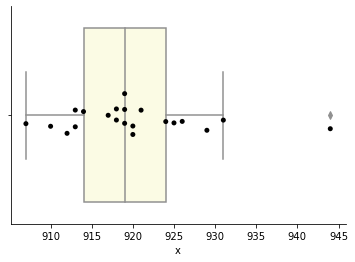

In [19]:
# Check the variability for the RW1 ROI x coordinate
rw1_rois_px = pd.read_csv(os.path.join(video_files_path, "ROIS", "%s_rw1_rois_px.csv"%ratcode), header=0, index_col=0)

fig = plt.Figure(figsize=(5,5))
sns.stripplot(data=rw1_rois_px, x='x', color='black')
sns.boxplot(data=rw1_rois_px, x='x', color='lightyellow')
plt.savefig(os.path.join(video_files_path,"ROIS", "%s_rw1_rois_px_variabilities.png"%ratcode))
sns.despine()

### <font color=orange> Choice point ROI

In [20]:
# Collect CP from video frames
collect_rois_df(video_files_path, 'cp_rois_px', ratcode)

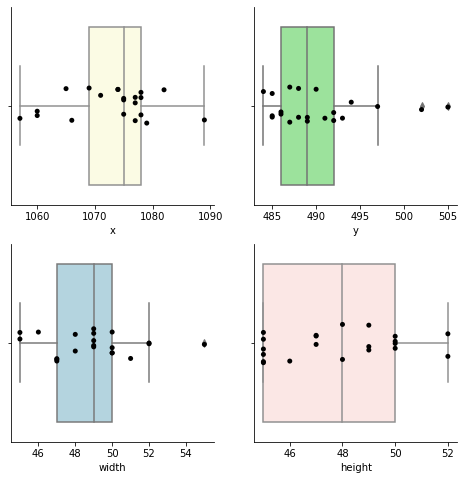

In [21]:
#Check the variability for the CP ROI coordinates and size
cp_rois_px = pd.read_csv(os.path.join(video_files_path, "ROIS", "%s_cp_rois_px.csv"%ratcode), header=0, index_col=0)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8,8))
cp_rois_px = cp_rois_px.mask(cp_rois_px['x']==0, cp_rois_px['x'].median())

sns.stripplot(data=cp_rois_px, x='x', color='black', ax=ax1)
ax1 = sns.boxplot(data=cp_rois_px, x='x', color='lightyellow', ax=ax1)

ax2 = sns.stripplot(data=cp_rois_px, x='y', color='black', ax=ax2)
ax2 = sns.boxplot(data=cp_rois_px, x='y', color='lightgreen', ax=ax2)

ax3 = sns.stripplot(data=cp_rois_px, x='width', color='black', ax=ax3)
ax3 = sns.boxplot(data=cp_rois_px, x='width', color='lightblue', ax=ax3)

ax4 = sns.stripplot(data=cp_rois_px, x='height', color='black',ax=ax4)
ax4 = sns.boxplot(data=cp_rois_px, x='height', color='mistyrose', ax=ax4)

sns.despine()
plt.savefig(os.path.join(video_files_path,"ROIS", "%s_cp_rois_px_variabilities.png"%ratcode))

### <font color=orange> RW2 port ROI x coordinate

In [23]:
# Collect RW2 roi from video frames
collect_rois_df(video_files_path, 'rw2_rois_px', ratcode)

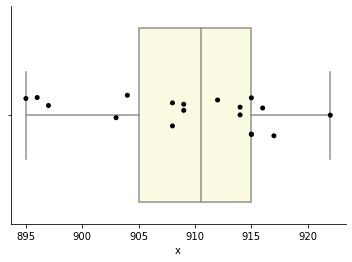

In [13]:
#Check the variability for the RW1 ROI x coordinate
rw2_rois_px = pd.read_csv(os.path.join(video_files_path, "ROIS", "%s_rw2_rois_px.csv"%ratcode), header=0, index_col=0)

fig = plt.Figure(figsize=(5,5))
sns.stripplot(data=rw2_rois_px, x='x', color='black')
sns.boxplot(data=rw2_rois_px, x='x', color='lightyellow')
plt.savefig(os.path.join(video_files_path,"ROIS", "%s_rw2_rois_px_variabilities.png"%ratcode))
sns.despine()

## <font color=mediumseagreen> Convert ROIs to CROP POLYGON measurments (adjustment of window pxs)

***
   #### Confirm the crop_polygon file path (where the window measurments are stored and mapped to rat if needed)

In [14]:
# Open crop_polygon measurments file
crop_polygon_file_path = "E:\MAZE_MEASURMENTS\CROP_POLYGON_TO_RAT_MAPPING.csv"
crop_polygon_measures = pd.read_csv(crop_polygon_file_path, header=0)

# Find the measurments mapped to the rat data being analyzed  
crop_poly_rat = crop_polygon_measures[crop_polygon_measures['rat'] == ratcode]

In [15]:
cp_rois_px = pd.read_csv(os.path.join(video_files_path, "ROIS", "%s_cp_rois_px.csv"%ratcode), header=0, index_col=0)
rw1_rois_px = pd.read_csv(os.path.join(video_files_path, "ROIS", "%s_rw1_rois_px.csv"%ratcode), header=0, index_col=0)
rw2_rois_px = pd.read_csv(os.path.join(video_files_path, "ROIS", "%s_rw2_rois_px.csv"%ratcode), header=0, index_col=0)

In [16]:
def convert_coord(df1, df2):
    df3 = df1.copy()
    
    df3['x'] = df1['x'] - df2['xmin'].iloc[0]
    df3['y'] = df1['y'] - df2['ymin'].iloc[0]
        
    print('Conversion to crop polygon window measurments done!')
    return df3

#Convert to crop_polygon window
rw1_rois_convert = convert_coord(rw1_rois_px, crop_poly_rat)
rw2_rois_convert = convert_coord(rw2_rois_px, crop_poly_rat)
cp_rois_convert = convert_coord(cp_rois_px, crop_poly_rat)
cp_rois_convert = convert_coord(cp_rois_px, crop_poly_rat)

Conversion to crop polygon window measurments done!
Conversion to crop polygon window measurments done!
Conversion to crop polygon window measurments done!
Conversion to crop polygon window measurments done!


## <font color=mediumseagreen> Convert measurments from pixels (px) to cm
***

In [17]:
def convert_px_to_cm(df, ratcode,filename):
    
    df_numeric = df.select_dtypes(include=['int64'])
    
    # Convert df data from px to cm
    df_numeric = (df_numeric*10)/50
    df_numeric['session'] = df['session']
    
    #Save df
    path=os.path.join(video_files_path, "ROIS", "%s_%s.csv"%(ratcode, filename))    
    df_numeric.to_csv(path,header=True)
    
    return df_numeric

#Convert pixels to cm (50 px = 10 cm)
rw1_rois = convert_px_to_cm(rw1_rois_convert, ratcode, 'rw1_rois_converted')
rw2_rois = convert_px_to_cm(rw2_rois_convert, ratcode, 'rw2_rois_converted')
cp_rois = convert_px_to_cm(cp_rois_convert, ratcode, 'cp_rois_converted')

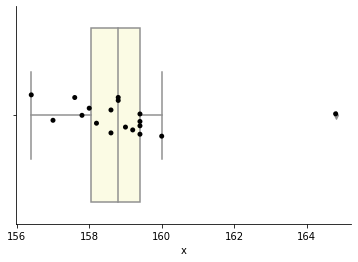

In [18]:
#Check the variability for the RW1 ROI x coordinate
fig = plt.Figure(figsize=(5,5))
sns.stripplot(data=rw1_rois, x='x', color='black')
sns.boxplot(data=rw1_rois, x='x', color='lightyellow')
plt.savefig(os.path.join(video_files_path,"ROIS", "%s_rw1_rois_converted_variabilities.png"%ratcode))
sns.despine()

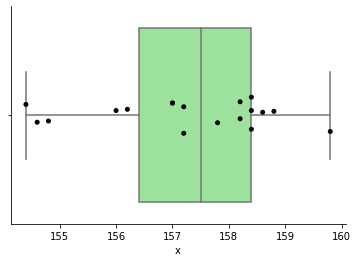

In [19]:
#Check the variability for the RW2 ROI x coordinate
fig = plt.Figure(figsize=(5,5))
sns.stripplot(data=rw2_rois, x='x', color='black')
sns.boxplot(data=rw2_rois, x='x', color='lightgreen')
plt.savefig(os.path.join(video_files_path,"ROIS", "%s_rw2_rois_converted_variabilities.png"%ratcode))
sns.despine()

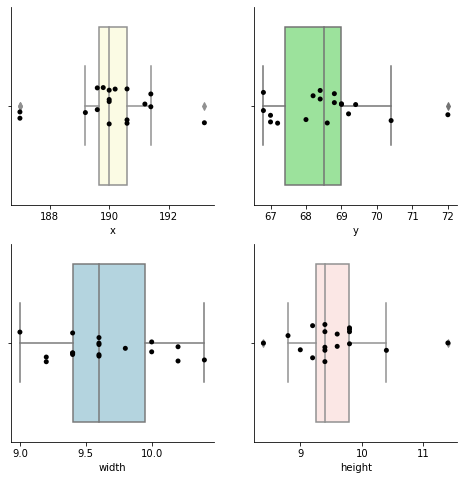

In [20]:
#Check the variability for the CP ROI coordinates and size upon conversion
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8,8))

sns.stripplot(data=cp_rois, x='x', color='black', ax=ax1)
ax1 = sns.boxplot(data=cp_rois, x='x', color='lightyellow', ax=ax1)

ax2 = sns.stripplot(data=cp_rois, x='y', color='black', ax=ax2)
ax2 = sns.boxplot(data=cp_rois, x='y', color='lightgreen', ax=ax2)

ax3 = sns.stripplot(data=cp_rois, x='width', color='black', ax=ax3)
ax3 = sns.boxplot(data=cp_rois, x='width', color='lightblue', ax=ax3)

ax4 = sns.stripplot(data=cp_rois, x='height', color='black',ax=ax4)
ax4 = sns.boxplot(data=cp_rois, x='height', color='mistyrose', ax=ax4)

sns.despine()
plt.savefig(os.path.join(video_files_path,"ROIS", "%s_cp_rois_converted_variabilities.png"%ratcode))